In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [2]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)
    
params = (0,1)
T = 100
A = pd.Series(index=range(T))
A.name = 'A'
for t in range(T):
    A[t] = generate_data(params)

B = pd.Series(index=range(T))
B.name = 'B'
for t in range(T):
    params = (t*0.1, 1)
    B[t] = generate_data(params)

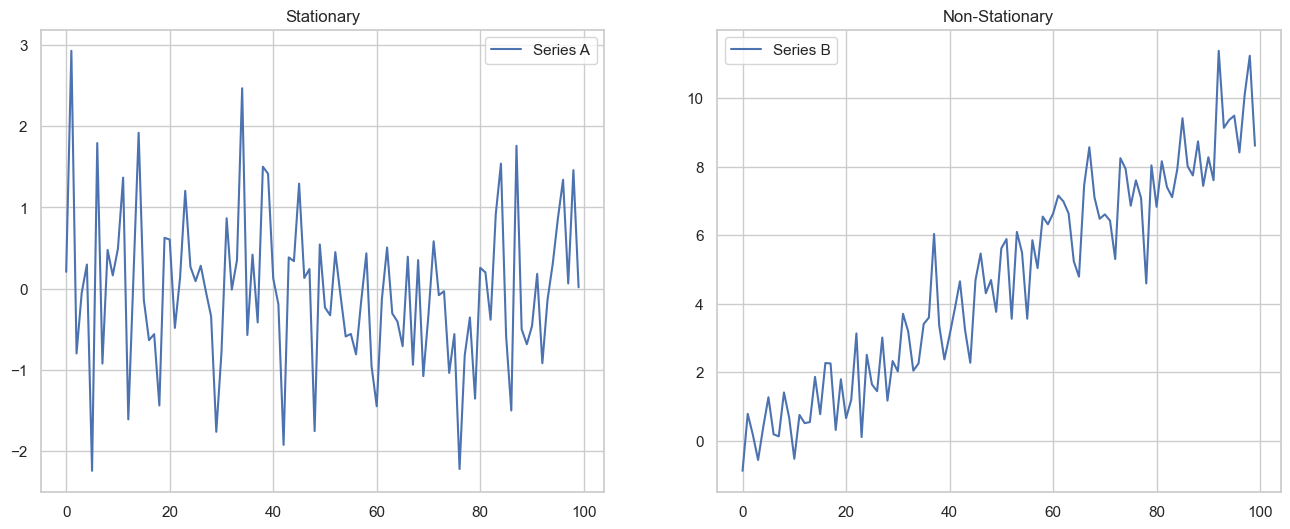

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(A)
ax2.plot(B)
ax1.legend(["Series A"])
ax2.legend(["Series B"])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')
plt.show()

In [4]:
def stationarity_test(X, cutoff=0.01):
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print("pvalue = " + str(pvalue) + " the series " + X.name + "is likely stationary")
    else:
        print("pvalue = " + str(pvalue) + " the series " + X.name + "is likely non-stationary")

In [5]:
stationarity_test(A)
stationarity_test(B)

pvalue = 4.069569203960384e-18 the series Ais likely stationary
pvalue = 0.9703674542968191 the series Bis likely non-stationary


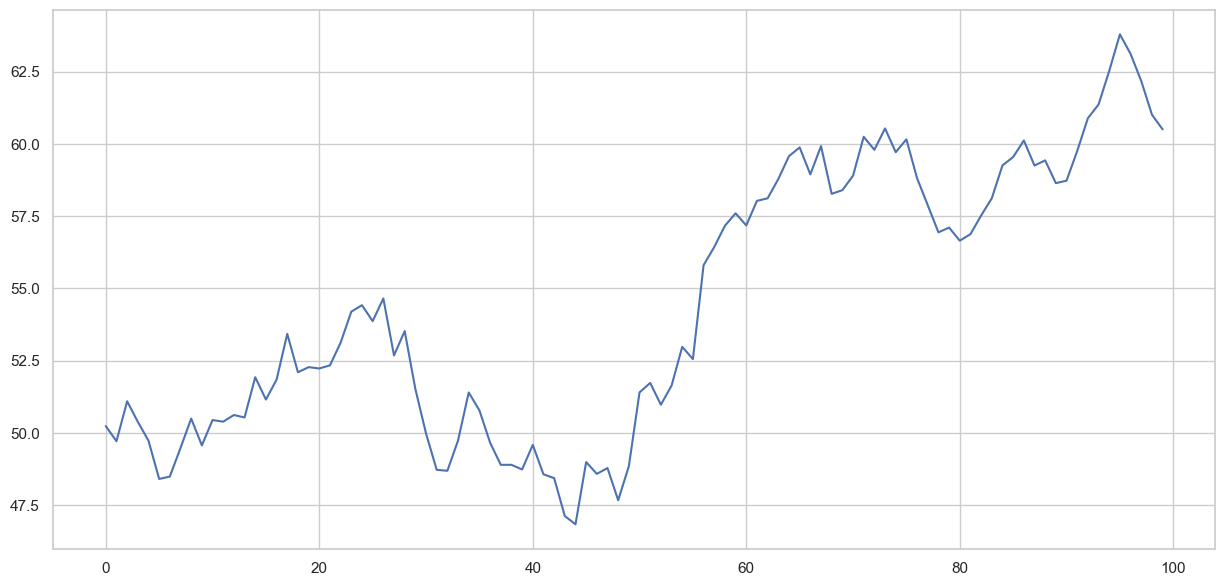

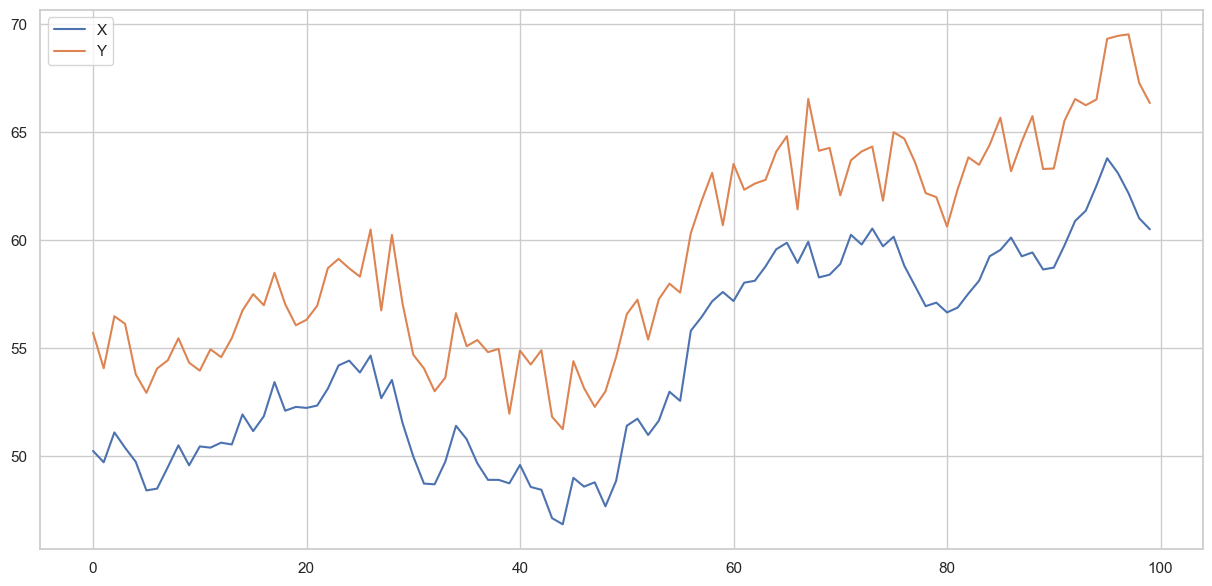

In [6]:
Xreturns = np.random.normal(0,1,100)
X = pd.Series(np.cumsum(Xreturns), name="X") + 50
X.plot(figsize=(15,7))

noise = np.random.normal(0,1,100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X,Y], axis = 1).plot(figsize=(15,7))

plt.show()

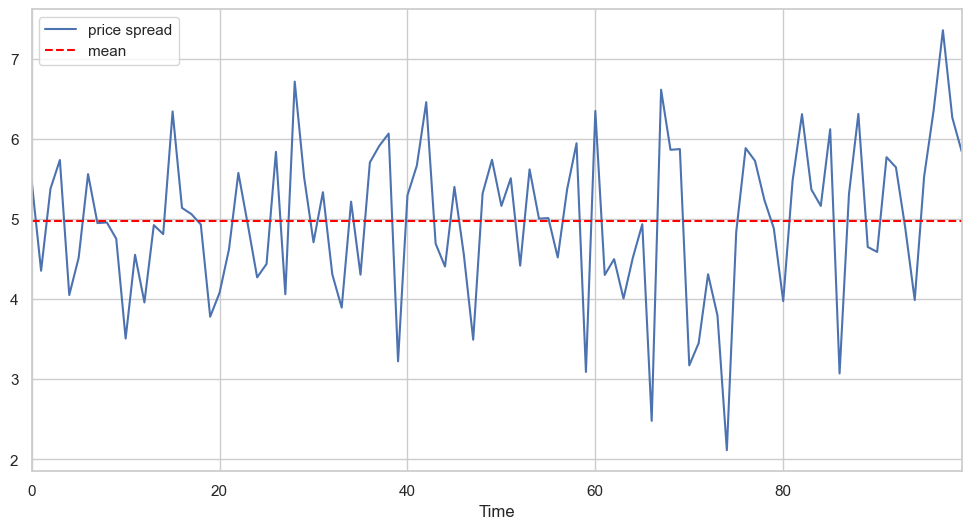

In [7]:
plt.figure(figsize=(12,6))
(Y-X).plot()
plt.axhline((Y-X).mean(), color='red', linestyle="--")
plt.xlabel("Time")
plt.xlim(0,99)
plt.legend(["price spread", "mean"])
plt.show()

In [8]:
score, pvalue, _ = coint(X,Y)
print(pvalue)

# Low pvalue means high cointegration!

4.267266905175753e-13


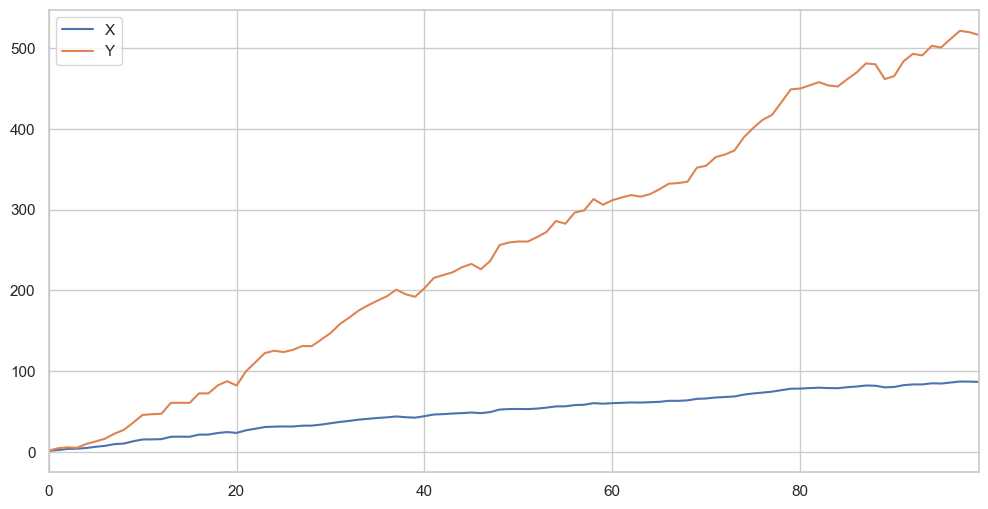

In [9]:
X_returns = np.random.normal(1, 1, 100)
noise = np.random.normal(0, 1, 100)

X = pd.Series(np.cumsum(X_returns), name='X')
Y = pd.Series(np.power(X, 1.4) + noise, name="Y")


pd.concat([X, Y], axis=1).plot(figsize=(12,6));
plt.xlim(0, 99)
plt.show()

In [10]:
print('Correlation: ' + str(X.corr(Y)))
score, pvalue, _ = coint(X,Y)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.9934968291245954
Cointegration test p-value: 0.9284306554432175


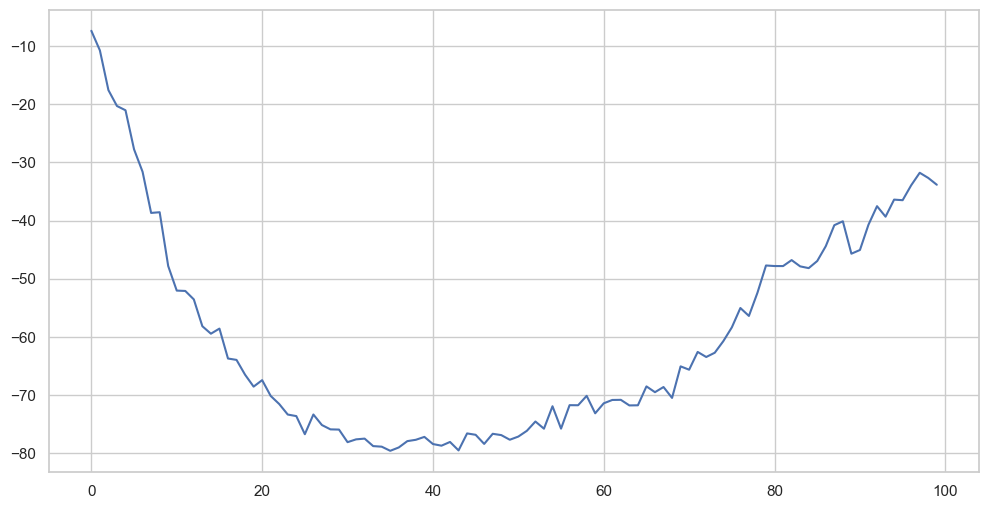

In [11]:
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
X = X["X"]

b = results.params['X']
spread = Y - b*X
spread.plot(figsize=(12,6))
plt.show()

In [12]:
import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY','NVDA']
data = pdr.data.get_data_yahoo(tickers, start='2013-01-01', end='2019-01-01')["Close"]
data.tail()

[*********************100%%**********************]  12 of 12 completed


Ticker,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,NVDA,ORCL,QCOM,SPY
Date,,,,,,,,,,,,
2018-12-24,36.707500,205.160004,16.650000,26.139999,19.379999,102.839386,25.559999,94.129997,31.770000,42.689999,53.650002,234.339996
2018-12-26,39.292500,222.949997,17.900000,27.850000,20.330000,106.491394,26.600000,100.559998,33.275002,44.590000,55.959999,246.179993
2018-12-27,39.037498,225.139999,17.490000,28.030001,20.379999,108.776291,26.799999,101.180000,32.792500,44.970001,56.090000,248.070007
2018-12-28,39.057499,223.130005,17.820000,28.240000,20.340000,108.059273,26.750000,100.389999,33.412498,44.820000,56.810001,247.750000
2018-12-31,39.435001,226.240005,18.459999,28.070000,20.459999,108.671127,26.910000,101.570000,33.375000,45.150002,56.910000,249.919998


In [13]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [14]:
score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(data)
pairs

[('AAPL', 'ORCL'),
 ('AAPL', 'SPY'),
 ('ADBE', 'MSFT'),
 ('AMD', 'MSFT'),
 ('HPQ', 'ORCL'),
 ('ORCL', 'SPY')]

In [15]:
S1 = data['ADBE']
S2 = data['MSFT']
score, pvalue, _ = coint(S1,S2)
pvalue

0.044526962716167726

In [22]:
def zscore(series):
    return (series - series.mean()) / np.std(series)
    
def trade(S1, S2):
    train_len = int(len(S1)*.7)
    S1_train = S1[:train_len]
    S1_test = S1[train_len:]
    S2_train = S2[:train_len]
    S2_test = S2[train_len:]
    
    S1_train = sm.add_constant(S1_train)
    results = sm.OLS(S2_train, S1_train).fit()
    S1_train = S1_train[S1_train.columns[1]]
    
    b = results.params[1]
    spread = S2_test - b*S1_test
    spread_n = (spread - spread.mean())/spread.std()
    
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(spread_n)):
        if spread_n[i] < -2:
            money += S1_test[i+1] - S2_test[i+1]/b
            countS1 -= 1
            countS2 += 1/b
        elif spread_n[i] > 2:
            money -= S1_test[i+1] - S2_test[i+1]/b
            countS1 += 1
            countS2 -= 1/b
        elif (abs(spread_n[i]) < 1e-2) | (abs(spread_n[i]>3)):
            money += S1_test[i+1]*countS1 + S2_test[i+1]*countS2
            countS1 = 0
            countS2 = 0
    
    return money

In [23]:
trade(S1, S2)

114.88463062430861